## Extracting drug assosiations

This notebook runs part of the Multi-Omics Variational autoEncoder (MOVE) framework for using the structure the VAE has identified for extracting categorical data assositions across all continuous datasets. In the MOVE paper we used it for identifiying drug assosiations in clinical and multi-omics data.

In [1]:
from move.data import io
from move.tasks import identify_associations

We will start by running the probabilistic approach to find associations between
the drugs dataset and the omics features.

In [2]:
config = io.read_config("random_small", "random_small__id_assoc_bayes")
identify_associations(config)

[INFO  - identify_associations]: Beginning task: identify associations (bayes)
[INFO  - identify_associations]: Perturbing dataset: 'random.small.drugs'
[INFO  - identify_associations]: Training models
[INFO  - identify_associations]: Identifying significant features
[INFO  - identify_associations]: Significant hits found: 127
[INFO  - identify_associations]: Writing results


This dataset includes 200 known associations, and MOVE could help identify 127
of them. Note that fiddling with the parameters of MOVE may improve this result;
however, many associations are rather small, so we do not expect to find them 
all.

The results are written in a TSV file, which we can read to compare against the
ground truth.

In [3]:
from pathlib import Path

import pandas as pd

raw_data_path = Path(config.data.raw_data_path)
results_path = Path(config.data.processed_data_path) / "identify_associations"

truth = pd.read_csv(raw_data_path / "changes.small.txt", sep="\t", index_col=0)
results = pd.read_csv(results_path / "results_sig_assoc.tsv", sep="\t")

All our hits are true positives!

In [4]:
merged = truth.merge(
    results,
    left_on=["drug_feature", "dataset_feature"],
    right_on=["feature_a_name", "feature_b_name"]
)

tp = len(merged)
fp = len(results) - len(merged)

print(f"False positives: {fp: 3}/{len(results)}\nTrue positives: {tp: 3}/{len(truth)}")

False positives:   0/127
True positives:  127/200


We can also run the t-test method, and compare both results.

Note that here we override the `processed_data_path` field to prevent overwriting
the previous results.

In [5]:
ttest_config = io.read_config("random_small", "random_small__id_assoc_ttest", "data.processed_data_path=results_ttest")
identify_associations(ttest_config)

[INFO  - identify_associations]: Beginning task: identify associations (ttest)
[INFO  - identify_associations]: Perturbing dataset: 'random.small.drugs'
[INFO  - identify_associations]: Training models
[INFO  - identify_associations]: Significant hits found: 119
[INFO  - identify_associations]: Writing results


We can now load the results, and check how the results of each method differ
from each other.

Note: you need to install `matplotlib_venn` to generate the Venn diagram below.

In [6]:
results_ttest_path = Path(config.data.processed_data_path) / "identify_associations"

results_ttest = pd.read_csv(results_ttest_path / "results_sig_assoc.tsv", sep="\t")

In [7]:
set_truth = set(truth["drug_feature"] + truth["dataset_feature"])
set_bayes = set(results["feature_a_name"] + results["feature_b_name"])
set_ttest = set(results_ttest["feature_a_name"] + results_ttest["feature_b_name"])

For this example dataset, the Bayes method got more hits than the t-test method.

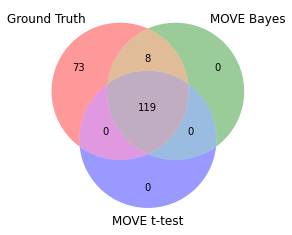

In [8]:
from matplotlib_venn import venn3_unweighted

_ = venn3_unweighted([set_truth, set_bayes, set_ttest], ["Ground Truth", "MOVE Bayes", "MOVE t-test"])